In [1]:
from func.utils import get_model_output_id_wnid_class_dict # get mapping: format: {"Model Ouput ID": ["WNID", "Class"]}
from func.utils import get_imagenet_id_wnid_class_dict # get mapping: format: {"ImageNet ID": ["WNID", "class"]}, e.g. {..."233": ['n02106382', 'Bouvier_des_Flandres'], ...}
from func.utils import map_model_id_to_imagenet_id, map_imagenet_id_to_model_id # mapping funcs

from func.utils import save_obj, load_obj, preprocess_image, get_pretrained_model, load_and_preprocess_image

from func.saliency_maps import conduct_saliency_map_method, GuidedBackprop, VanillaBackprop, SmoothGrad, GradCAM, GuidedGradCAM, IntegratedGradients, GradientxInput

from func.responsible_regions import load_responsible_regions_from_given_path, X_y_preparation, process_cat_saliency_map

from func.concept_classifier import get_linear_classifier, get_xgb_classifier, prediction

from func.show import load_feature_saliency_map_and_resized_img_for_show, show_concept_region_on_img

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import gc
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import copy
from skimage.transform import resize
import xml.etree.ElementTree as ET

In [2]:
# get the dict of ImageNet ID, WNID and class name
# format: {"ImageNet ID": ["WNID", "class"]}, e.g. {..."233": ['n02106382', 'Bouvier_des_Flandres'], ...}
imagenet_id_label=get_imagenet_id_wnid_class_dict(matfilepath = "imagenet_info/ILSVRC2012_meta.mat")

# get the dict of model output ID, WNID and class name
# format: {"Model Ouput ID": ["WNID", "Class"]}
modeloutput_id_label=get_model_output_id_wnid_class_dict(jsonfilepath = "imagenet_info/imagenet_label_index.json")

# get dict map model output ID to ImageNet ID
map_dict_model2imagenet=map_model_id_to_imagenet_id(imagenet_id_label, modeloutput_id_label)

# get ImageNet ID to dict map model output ID
map_dict_imagenet2model=map_imagenet_id_to_model_id(imagenet_id_label, modeloutput_id_label)

### show image classes

In [3]:
# only 1~1000 is valid
for idx in imagenet_id_label:
    print(str(idx)+": "+str(imagenet_id_label[idx]))

1: ['n02119789', 'kit fox, Vulpes macrotis']
2: ['n02100735', 'English setter']
3: ['n02110185', 'Siberian husky']
4: ['n02096294', 'Australian terrier']
5: ['n02102040', 'English springer, English springer spaniel']
6: ['n02066245', 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus']
7: ['n02509815', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens']
8: ['n02124075', 'Egyptian cat']
9: ['n02417914', 'ibex, Capra ibex']
10: ['n02123394', 'Persian cat']
11: ['n02125311', 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor']
12: ['n02423022', 'gazelle']
13: ['n02346627', 'porcupine, hedgehog']
14: ['n02077923', 'sea lion']
15: ['n02110063', 'malamute, malemute, Alaskan malamute']
16: ['n02447366', 'badger']
17: ['n02109047', 'Great Dane']
18: ['n02089867', 'Walker hound, Walker foxhound']
19: ['n02102177', 'Welsh springer spaniel']
20: ['n02091134', 'whippet']
21: ['n02092002', 'Scottish deerhound, deerhound']
22: [

1536: ['n02788689', 'bar']
1537: ['n03659292', 'lever']
1538: ['n03613592', 'key']
1539: ['n04285622', 'sports implement']
1540: ['n03094503', 'container']
1541: ['n04576211', 'wheeled vehicle']
1542: ['n02834778', 'bicycle, bike, wheel, cycle']
1543: ['n02959942', 'car, railcar, railway car, railroad car']
1544: ['n03484083', 'handcart, pushcart, cart, go-cart']
1545: ['n04170037', 'self-propelled vehicle']
1546: ['n02740533', 'armored vehicle, armoured vehicle']
1547: ['n03684823', 'locomotive, engine, locomotive engine, railway locomotive']
1548: ['n03791235', 'motor vehicle, automotive vehicle']
1549: ['n02958343', 'car, auto, automobile, machine, motorcar']
1550: ['n03790512', 'motorcycle, bike']
1551: ['n03769722', 'minibike, motorbike']
1552: ['n04490091', 'truck, motortruck']
1553: ['n04520170', 'van']
1554: ['n03896419', 'passenger van']
1555: ['n04464852', 'tracked vehicle']
1556: ['n04467099', 'trailer, house trailer']
1557: ['n04543158', 'wagon, waggon']
1558: ['n02970849',

### imagenet parent and child dict

In [4]:
imagenet_class_parent_and_child_dict = load_obj("imagenet_info/imagenet_class_dict")

### show VOC2007 annotations

In [5]:
anno_path = "/data/Pascal_VOC_dataset/VOCdevkit/VOC2007/Annotations"

anno_files = os.listdir(anno_path)

In [6]:
def get_obj_classes(anno_xml_file_path):
    tree = ET.parse(anno_xml_file_path)
    root = tree.getroot()
    
    obj_classes = []
    
    for item in root:
        for subitem in item:
            if subitem.tag == "name":
                obj_classes.append(subitem.text)
    
    return obj_classes

In [7]:
classes = []
for idx, anno_file in enumerate(anno_files):
    current_obj_classes = get_obj_classes(anno_path+"/"+anno_file)
    classes+=current_obj_classes
    print(str(idx)+" | "+str(anno_file)+": "+str(current_obj_classes), end="\r")

3789 | 006176.xml: ['Lila ?', 'person', 'person']

In [8]:
classes_unique, unique_count = np.unique(classes, return_counts = True)
# for a in classes_unique[np.argsort(unique_count)][::-1]:
#     print(a)
classes_in_voc = ["person",
                  "car",
                  "chair",
                  "bottle",
                  "pottedplant",
                  "bird",
                  "dog",
                  "sofa",
                  "bicycle",
                  "horse",
                  "boat",
                  "motorbike",
                  "cat",
                  "tvmonitor",
                  "cow",
                  "sheep",
                  "aeroplane",
                  "train",
                  "diningtable",
                  "bus"]

In [9]:
target_class_dict = {"person": 15, "bird": 3, "dog": 12, "horse": 13, "cat": 8, "cow": 10, "sheep": 17}

### show VOC2007 images

In [10]:
target = "sheep"
for idx, pic_name in enumerate(os.listdir("/data/Pascal_VOC_dataset/VOCdevkit/VOC2007/SegmentationClass")):
    current_obj_classes = get_obj_classes(anno_path+"/"+pic_name.split(".")[0]+".xml")
    if target in current_obj_classes:
        print(pic_name)
        break

004423.png


In [11]:
# set the paths
voc_img_path = "/data/Pascal_VOC_dataset/VOCdevkit/VOC2007/JPEGImages"
voc_seg_path = "/data/Pascal_VOC_dataset/VOCdevkit/VOC2007/SegmentationClass"

In [12]:
img_name = pic_name.split(".")[0]+".jpg"
seg_name = pic_name.split(".")[0]+".png"

In [13]:
# load img
# resize_im=(224,224)
# preprocessed_img_tensor, resized_img = load_and_preprocess_image(voc_img_path+"/"+img_name, resize_im=resize_im)
img = Image.open(voc_img_path+"/"+img_name)
img = np.array(img)
# load seg
seg = Image.open(voc_seg_path+"/"+seg_name)
seg = np.array(seg)

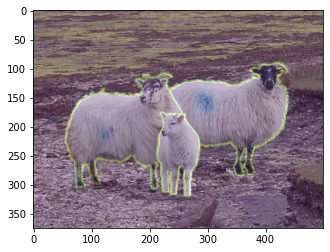

In [14]:
# show_concept_region_on_img(img, seg)
plt.imshow(img)
plt.imshow(seg, alpha=0.3)

In [ ]:
# show all the images
resize_im = (224, 224)
num_of_pic_a_row = 10
num_of_col = np.ceil(len(os.listdir(voc_seg_path))/num_of_pic_a_row)
a_big_pic = np.zeros((int(resize_im[0]*num_of_col), int(resize_im[1]*num_of_pic_a_row), 3))
a_big_pic = np.array(a_big_pic, dtype=np.int)
for idx, pic_name in enumerate(os.listdir(voc_seg_path)):
    print(str(idx)+": "+pic_name.split(".")[0], end="\r")
    which_col = np.floor(idx/num_of_pic_a_row)
    which_row = idx - num_of_pic_a_row*which_col
    
    img_name = pic_name.split(".")[0]+".jpg"
    _, img = load_and_preprocess_image(voc_img_path+"/"+img_name, resize_im=resize_im)
    
    a_big_pic[int(which_col*resize_im[0]):int((which_col+1)*resize_im[0]),
              int(which_row*resize_im[1]):int((which_row+1)*resize_im[1]), :]=img

In [ ]:
plt.figure(figsize=(20,100))
plt.imshow(a_big_pic)

In [ ]:
# show the gt seg of the target class
target = "person"
a_big_seg = np.zeros((int(resize_im[0]*num_of_col), int(resize_im[1]*num_of_pic_a_row)))
for idx, pic_name in enumerate(os.listdir(voc_seg_path)):
    which_col = np.floor(idx/num_of_pic_a_row)
    which_row = idx - num_of_pic_a_row*which_col
    current_obj_classes = get_obj_classes(anno_path+"/"+pic_name.split(".")[0]+".xml")
    if target in current_obj_classes:
        print(str(idx)+": "+pic_name.split(".")[0], end="\r")
        seg = Image.open(voc_seg_path+"/"+pic_name.split(".")[0]+".png")
        seg = resize(np.array(np.asarray(seg)==target_class_dict[target], dtype=int), (resize_im[0], resize_im[1]))
        a_big_seg[int(which_col*resize_im[0]):int((which_col+1)*resize_im[0]),
                  int(which_row*resize_im[1]):int((which_row+1)*resize_im[1])]=seg

In [ ]:
show_concept_region_on_img(a_big_pic, a_big_seg, figsize=(20,100))

### load img from VOC2007

In [15]:
seg_names = os.listdir(voc_seg_path)

target_pic_names = []

for seg_name in seg_names:
    target_pic_names.append(seg_name.split(".")[0])

# choose a pic
chosen_pic = 3

for idx, target_pic_name in enumerate([target_pic_names[chosen_pic]]):
    print(target_pic_name)
    img_name = target_pic_name+".jpg"
    seg_name = target_pic_name+".png"

008815


In [16]:
# load img
resize_im=(224,224)
preprocessed_img_tensor, resized_img = load_and_preprocess_image(voc_img_path+"/"+img_name, resize_im=resize_im)
# load seg
seg = Image.open(voc_seg_path+"/"+seg_name)
seg = np.array(seg)

def find_class_mask_of_seg(seg):
    unique_vals = np.unique(seg)
    class_mask_dict = {}
    for val in unique_vals:
        if val!=0 and val!=255:
            class_mask = np.zeros(seg.shape)
            class_mask[seg==val] = 1
            class_mask_dict[val] = class_mask
    return class_mask_dict
class_mask_dict = find_class_mask_of_seg(seg)

def only_keep_the_foreground_mask_of_seg(seg):
    seg[seg==255]=0
    return seg

class_mask_dict = find_class_mask_of_seg(seg)

def cal_point_game_score_and_iou(seg, output_mask):
    output_mask_resized = resize(np.array(output_mask>0, dtype=np.float), (seg.shape[0], seg.shape[1]))
    seg_resized = resize(np.array(seg>0, dtype=np.float), (output_mask.shape[0], output_mask.shape[1]))
    seg_resized_onehot = np.array(seg_resized>0.5, dtype=np.int)

    #point_game_score = np.sum(np.multiply(class_mask_resized_onehot, output_mask)) / np.sum(output_mask)
    point_game_score = np.sum(np.multiply(np.array(seg>0, dtype=np.float), output_mask_resized)) / np.sum(output_mask_resized)
        
    #iou = np.sum(np.multiply(class_mask_resized_onehot, output_mask)) / \
    #np.sum(np.array(class_mask_resized_onehot+output_mask>0, dtype=np.int))
    iou = np.sum(np.multiply(np.array(seg>0, dtype=np.float), output_mask_resized)) / \
    np.sum(np.array(np.array(seg>0, dtype=np.float)+output_mask_resized>0, dtype=np.int))

    return point_game_score, iou

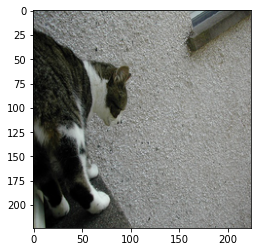

In [17]:
plt.imshow(resized_img)

### load model (VGG19 as example)

In [18]:
model_name = "vgg19"

which_layer_to_hook = ["features.30"]

salient_method = GuidedBackprop

pretrained_model = get_pretrained_model(model_name, True)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("model structure:\n"+str(pretrained_model))

model structure:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), st

In [19]:
saliency_map, feature_map, _ = conduct_saliency_map_method(salient_method, preprocessed_img_tensor, None,
                                                           pretrained_model, which_layer_to_hook=which_layer_to_hook,
                                                           device=device)

Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [20]:
chosen_layer = which_layer_to_hook[0]

### load concept clf

In [21]:
clf_dict = load_obj("output/concept_clf/concept_clf_whole_vgg19")
clf = clf_dict["clf"]
print(clf_dict["info"])

{'name': 'whole classifier', 'model': 'vgg19', 'layer': 'features.30'}


### localization

In [22]:
pred = prediction(clf, feature_map[chosen_layer])

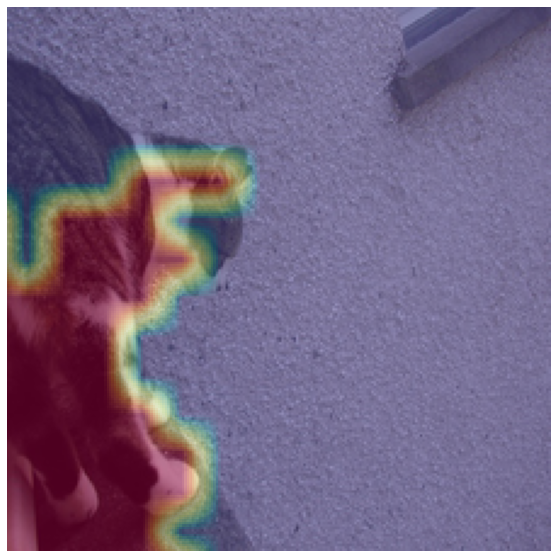

In [23]:
show_concept_region_on_img(resized_img,pred)

### accuracy

In [24]:
point_game_score, iou = cal_point_game_score_and_iou(seg, pred)

/tmp/ipykernel_48923/2708733355.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_mask_resized = resize(np.array(output_mask>0, dtype=np.float), (seg.shape[0], seg.shape[1]))
/tmp/ipykernel_48923/2708733355.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_resized = resize(np.array(seg>0, dtype=np.float), (output_mask.sha

In [25]:
point_game_score, iou,

(0.8340742961516132, 0.5123549414008902)

### preform the concept clf on multi images

In [26]:
chosen_pics = np.arange(0,8*15)
resize_im=(224,224)

img_list = []
seg_list = []
pred_list = []

target_pic_names = np.array(target_pic_names)
for idx, target_pic_name in enumerate(target_pic_names[chosen_pics]):
    print(str(idx/len(chosen_pics))+": "+target_pic_name, end="\r")
    img_name = target_pic_name+".jpg"
    seg_name = target_pic_name+".png"
    
    # load img
    preprocessed_img_tensor, img = load_and_preprocess_image(voc_img_path+"/"+img_name, resize_im=resize_im)
    # load seg
    seg = Image.open(voc_seg_path+"/"+seg_name)
    seg = np.array(seg)
    
    img_list.append(img)
    seg_list.append(seg)
    
    saliency_map, feature_map, _ = conduct_saliency_map_method(salient_method, preprocessed_img_tensor, None,
                                                               pretrained_model, which_layer_to_hook=which_layer_to_hook,
                                                               device=device)
    
    pred = prediction(clf, feature_map[chosen_layer])
    
    pred_list.append(pred)

/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWa

Guided Backpropagation
Guided Backpropagation
Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWa

Guided Backpropagation
Guided Backpropagation
Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWa

Guided Backpropagation
Guided Backpropagation
Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWa

Guided Backpropagation
Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWa

Guided Backpropagation
Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWa

Guided Backpropagation
Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWa

Guided Backpropagation
Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWa

Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation
Guided Backpropagation5845


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


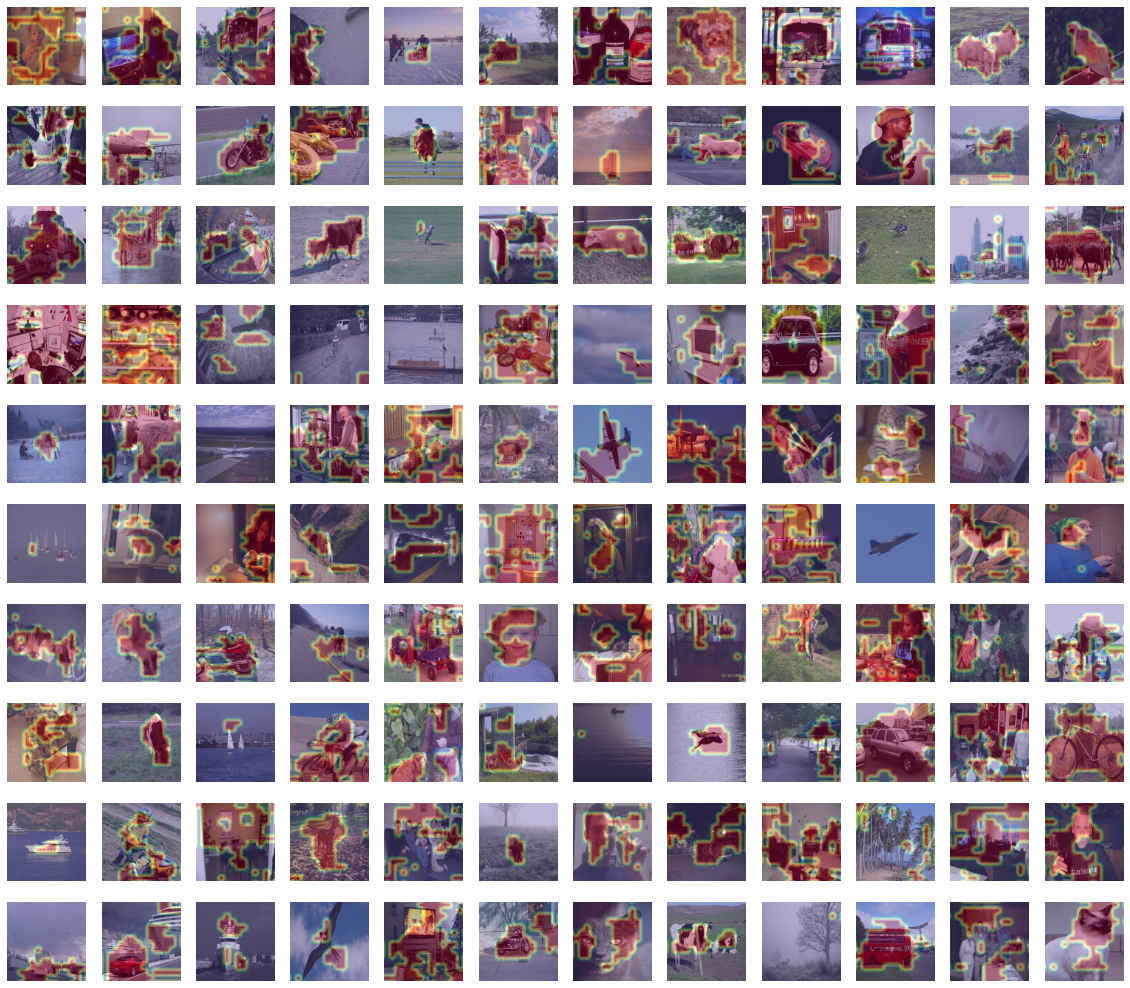

In [27]:
# result of concept clf
fig = plt.figure(figsize=(20, 18))

num_of_row = 12
num_of_col = int(np.ceil(len(chosen_pics)/num_of_row))

gs = gridspec.GridSpec(num_of_col, num_of_row)

for pic_idx in range(len(chosen_pics)):
    current_img = img_list[pic_idx]
    current_pred = pred_list[pic_idx].astype(float)
    which_col = int(np.floor(pic_idx/num_of_row))
    which_row = int(pic_idx - num_of_row*which_col)
    
    ax = fig.add_subplot(gs[which_col, which_row])
    ax.imshow(current_img)
    current_pred_resize = resize(current_pred, (current_img.shape[0], current_img.shape[1]))
    if np.sum(current_pred_resize) == 0:
        current_pred_resize[0,0] = 1
    ax.matshow(-current_pred_resize, cmap='Spectral', alpha=0.4)
    ax.axis('off')

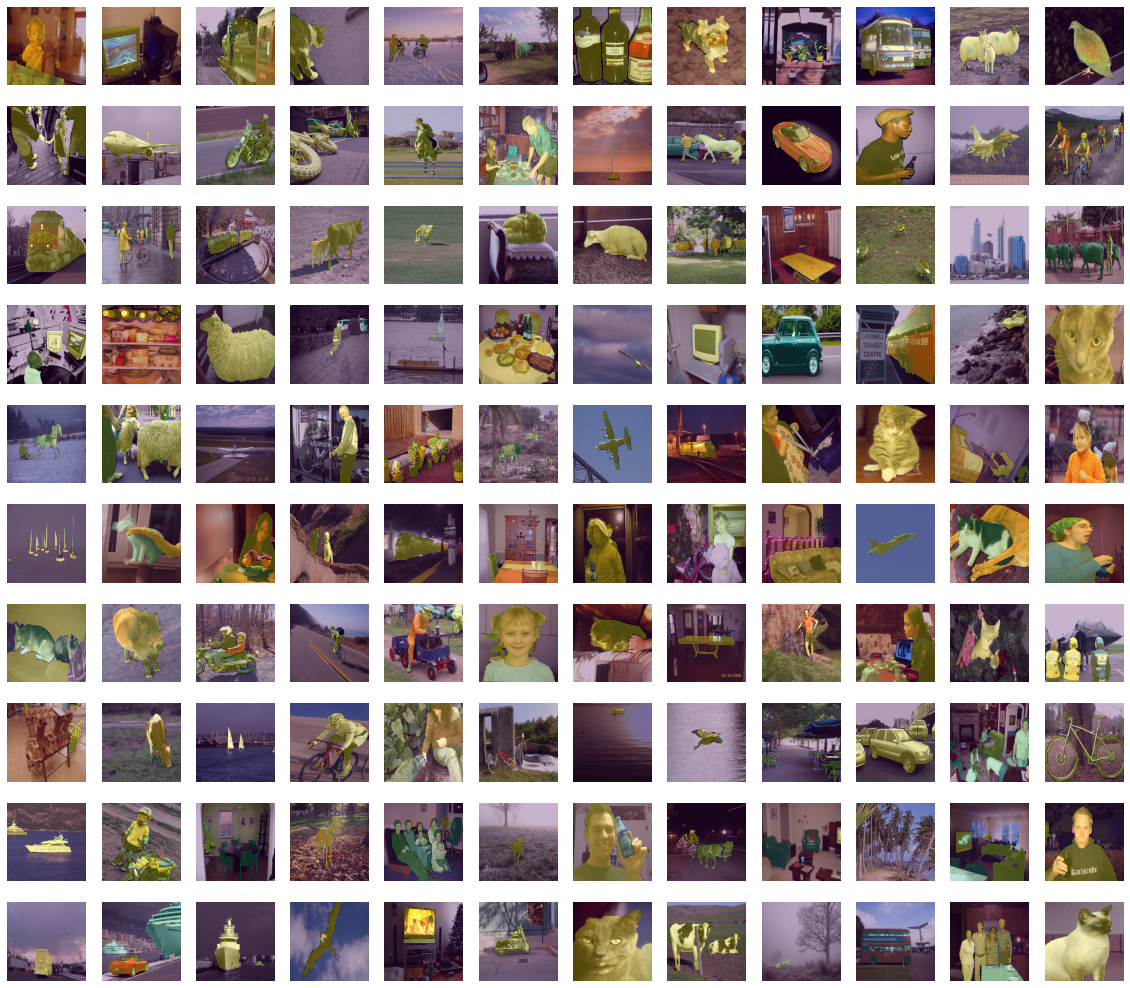

In [28]:
# gt

fig = plt.figure(figsize=(20, 18))

num_of_row = 12
num_of_col = int(np.ceil(len(chosen_pics)/num_of_row))

gs = gridspec.GridSpec(num_of_col, num_of_row)

for pic_idx in range(len(chosen_pics)):
    current_img = img_list[pic_idx]
    current_seg = seg_list[pic_idx].astype(float)
    which_col = int(np.floor(pic_idx/num_of_row))
    which_row = int(pic_idx - num_of_row*which_col)
    
    ax = fig.add_subplot(gs[which_col, which_row])
    ax.imshow(current_img)
    current_seg = only_keep_the_foreground_mask_of_seg(current_seg)
    current_seg = resize(current_seg, (current_img.shape[0], current_img.shape[1]))
    ax.matshow(current_seg,alpha=0.3)
    ax.axis('off')